In [4]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum
from timescales.sim.exp import sim_spikes_synaptic
from timescales.est.psd import fit_psd, convert_knee_val
from timescales.est.acf import fit_acf, compute_acf

### Spectral Estimation Comparisons

This notebook compares how different spectral estimation methods (welch vs medfilt vs wavelets) compare. A large tau is simulated, which is known to result in poor estimates via welch's method.

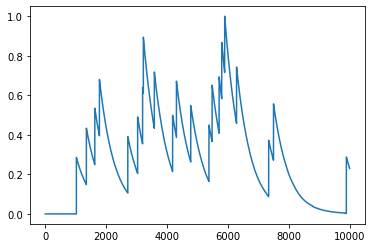

In [2]:
n_seconds = 10
fs = 1000

tau = .5
n_neurons = 1
mu = 500

probs = np.zeros((100, int(fs * n_seconds)))

for i in range(100):
    _probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons, mu=mu)
    probs[i] = _probs
    
plt.plot(probs[0]);

In [6]:
freqs_welch, powers_welch = compute_spectrum(probs, fs, method='welch')

freqs_med, powers_med = compute_spectrum(probs, fs, method='medfilt')

freqs_wave, powers_wave = compute_spectrum(probs, fs, method='wavelet',
                                           freqs=freqs_med[np.where(freqs_med >= 1)[0]])

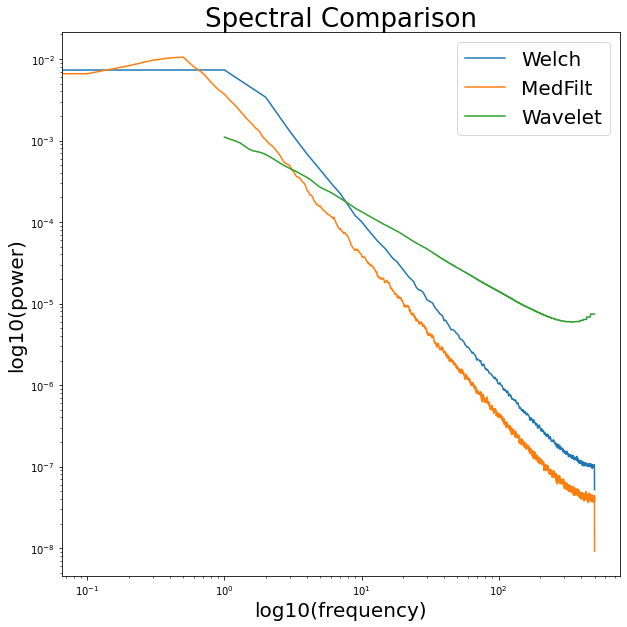

In [75]:
plt.figure(figsize=(10, 10))

plt.loglog(freqs_welch, powers_welch.mean(axis=0), label='Welch')
plt.loglog(freqs_med, powers_med.mean(axis=0), label='MedFilt')
plt.loglog(freqs_wave, powers_wave.mean(axis=0), label='Wavelet')
plt.xlabel('log10(frequency)', size=20)
plt.ylabel('log10(power)', size=20)
plt.title('Spectral Comparison', size=26)
plt.legend(fontsize=20);

In [76]:
# Fit fooof
fooof_init = {'max_n_peaks': 0}

fg_welch, kf_welch, kt_welch = fit_psd(freqs_welch, powers_welch, (1, 200),
                                       fooof_init=fooof_init, knee_bounds=(0, 100))

fg_med, kf_med, kt_med = fit_psd(freqs_med, powers_med, (1, 200),
                                 fooof_init=fooof_init, knee_bounds=(0, 100))

fg_wave, kf_wave, kt_wave = fit_psd(freqs_wave, powers_wave, (1, 200),
                                    fooof_init=fooof_init, knee_bounds=(0, 100))

# Fit ACF
corrs = compute_acf(probs, len(probs))
params = fit_acf(corrs)

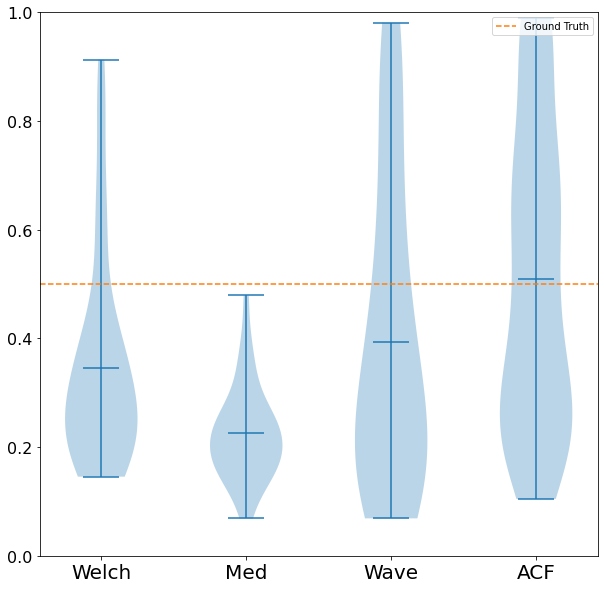

In [99]:
# Plot fooof
plt.figure(figsize=(10, 10))

max_tau = 1
inds_welch = np.where((kt_welch < max_tau))[0]
inds_med = np.where((kt_med < max_tau))[0]
inds_wave = np.where((kt_wave < max_tau))[0]
plt.violinplot([kt_welch[inds_welch], kt_med[inds_med], kt_wave[inds_wave], params[:, 0]/fs], showmeans=True)
plt.axhline(tau, color='C1', ls='dashed', label='Ground Truth')
plt.ylim(0, 1)
plt.yticks(size=16)
plt.xticks([1, 2, 3, 4], ['Welch', 'Med', 'Wave', 'ACF'], size=20)
plt.legend();